# $$ \text{Imágenes Satelitales} \cap \text{Python} $$


 Datos: para este taller utilizamos una imagen Landsat8. Lo que hice previamente fue ir a https://earthexplorer.usgs.gov/ y bajarme la imagen que me interesaba (recuerden que para Level 2 uno la pide y se la pueden bajar recien al otro dia). Igualmente para que puedan empezar a jugar les dejo el link a la imagen con la que trabajamos, la subi a un drive: el nombre del archivo es "LC082250842018021301T1-SC20180427103449.tar". Lo unico que hice fue descomprimirlo y guardarlo en una carpeta que se llama "L8_225084". El archivo LC082250842018021301T1-SC20180427103449.tar se lo pueden bajar de:
https://drive.google.com/drive/folders/1oXZJR4rHiAJO4yJnyx8xuAw1XgfOrOmd

Siempre esta bueno chequear el Manual de la imagen con la que uno va a trabajar, el manual o handbook suele aportar informacion acerca del contenido de los datos que se baja y tambien ns avisa si es necesario, por ejemplo, multiplicar los datos por alguna constante para que representen la magnitud fisica de interes. En nuestro caso, las Landsat8 hay que multiplicarlas por 0.0001 y asi cada pixel estara representando la reflectancia en superficie. Pueden buscarlo online, igualmente lo subo a mi github asi queda todo junto (@okuspokus).



## 0. Importamos (algunas) de las librerías que vamos a utilizar: 

In [1]:
%matplotlib notebook
#%matplotlib nbagg 
# va a ser importante utilizat nbagg o notebook, en este caso inline no
# ns servira porque querremos interactuar con los gráficos.
import matplotlib.pyplot as plt
import gdal
import numpy as np
from skimage import exposure
import pandas as pd
# import seaborn as sns



def firmas_teo():
    # Muchos de estos datos los pude obtener gracias a Maira Gayol, muchas gracias!
    x = [1,2,3,4,5,6]
    plt.plot(x,[0.03,0.05,0.04,0.4,0.14,0.07],color='g',label='vegetacion densa',marker='o')
    plt.plot(x,[0.03,0.05,0.04,0.27,0.12,0.07],color='g',label='vegetacion no densa',marker='o')

    plt.plot(x,[0.05,0.11,0.13,0.06,0.02,0.01],color='brown',label='agua turbia',marker='o')
    plt.plot(x,[0.03,0.04,0.035,0.05,0.02,0.01],color='b',label='agua clara',marker='o')
    plt.plot(x,[ 0.10, 0.13, 0.15, 0.26, 0.25, 0.21],color='gray',label='ciudad',marker='o')
    #plt.plot(x,[4,3,2,5],color='b',label='vegetacion')
    plt.ylim(0.0,0.5)
    plt.legend()
    plt.xticks(np.arange(1,7),('Blue','Green','Red','NIR','SWIR1','SWIR2'))
    plt.xlabel('Bandas')
    plt.ylabel('Reflectancia')


def array2raster_1band(out_name,array,geo_trans,proj):
    # https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
    # http://blog.remotesensing.io/2013/03/using-gdal-with-python-basic-intro/

    # First of all, gather some information from the original file
    cols,rows = array.shape
    trans       = geo_trans
    proj        = proj
    #nodatav     = data.GetNoDataValue()
    outfile     = out_name

    # Create the file, using the information from the original file
    outdriver = gdal.GetDriverByName("GTiff")
    outdata   = outdriver.Create(str(outfile), rows, cols, 1, gdal.GDT_Float32)

    # Georeference the image
    outdata.SetGeoTransform(trans)

    # Write projection information
    outdata.SetProjection(proj)

    band = outdata.GetRasterBand(1)
    band.WriteArray(array)
    band.FlushCache()
    

def array2raster(out_name,array,geo_trans,proj):
    # First of all, gather some information from the original file
    cols,rows,bands = array.shape



    # Create the file, using the information from the original file
    outdriver = gdal.GetDriverByName("GTiff")
    outdata   = outdriver.Create(str(outfile), rows, cols, bands, gdal.GDT_Float32)


    # Georeference the image
    outdata.SetGeoTransform(trans)

    # Write projection information
    outdata.SetProjection(proj)


    for i in range(1,4):
        band = outdata.GetRasterBand(i)
        band.WriteArray(array[i-1,:,:])
        band.FlushCache()


<IPython.core.display.Javascript object>


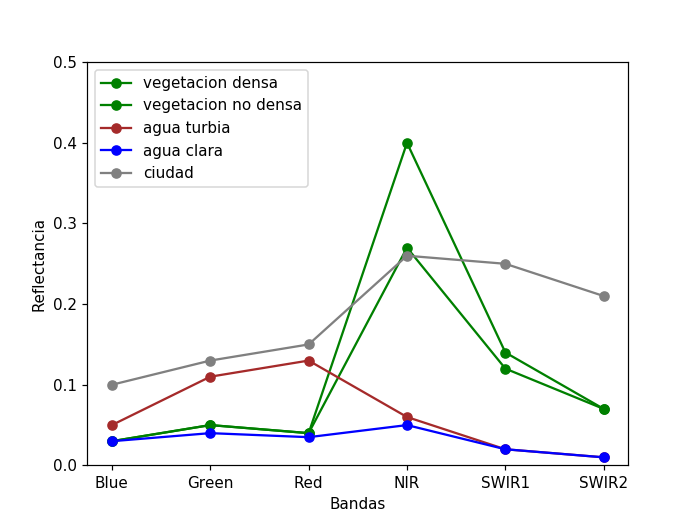

In [2]:
firmas_teo()

## 1. Importamos las bandas, creamos un stack y clipeamos la imagen:

### 1.1 Levantamos las bandas y hacemos el stack:

In [3]:
import glob

src = 'L8_225084/'

tifs = glob.glob(src+'/*_sr_band?.tif')
tifs.sort()

tifs

['L8_225084/LC08_L1TP_225084_20180213_20180222_01_T1_sr_band1.tif',
 'L8_225084/LC08_L1TP_225084_20180213_20180222_01_T1_sr_band2.tif',
 'L8_225084/LC08_L1TP_225084_20180213_20180222_01_T1_sr_band3.tif',
 'L8_225084/LC08_L1TP_225084_20180213_20180222_01_T1_sr_band4.tif',
 'L8_225084/LC08_L1TP_225084_20180213_20180222_01_T1_sr_band5.tif',
 'L8_225084/LC08_L1TP_225084_20180213_20180222_01_T1_sr_band6.tif',
 'L8_225084/LC08_L1TP_225084_20180213_20180222_01_T1_sr_band7.tif']

In [4]:
l8_stack_vrt_name =src+'l8_stack_vrt.vrt'

l8_stack_vrt = gdal.BuildVRT(l8_stack_vrt_name,tifs, separate=True)


# This program builds a VRT (Virtual Dataset) that is a mosaic of the list of input GDAL datasets.
#The list of input GDAL datasets can be specified at the end of the command line, or put in a text file
#(one filename per line) for very long lists, or it can be a MapServer tileindex (see gdaltindex utility).
#In the later case, all entries in the tile index will be added to the VRT.
# With -separate, each files goes into a separate band in the VRT band. Otherwise, the files are
#considered as tiles of a larger mosaic and the VRT file has as many bands as one of the input files.


l8_stack_tif_name = src+'l8_stack.tif'
l8_stack = gdal.Translate(l8_stack_tif_name,l8_stack_vrt)

#The gdal_translate utility can be used to convert raster data between different formats, potentially performing some operations like subsettings, resampling, and rescaling pixels in the process.

In [5]:

print("Formato: ", l8_stack.GetDriver().LongName)
print("En total tiene  bandas", l8_stack.RasterCount )
print("En total tiene  filas" , l8_stack.RasterYSize)
print("En total tiene  columnas", l8_stack.RasterXSize)




Formato:  GeoTIFF
En total tiene  bandas 7
En total tiene  filas 7731
En total tiene  columnas 7681


In [ ]:
#img_geotransform = l8_stack.GetGeoTransform()
#print("La esquina arriba a la izquierda, tiene coordenadas:")
#print("La resolución de los pxeles es: ")




<IPython.core.display.Javascript object>


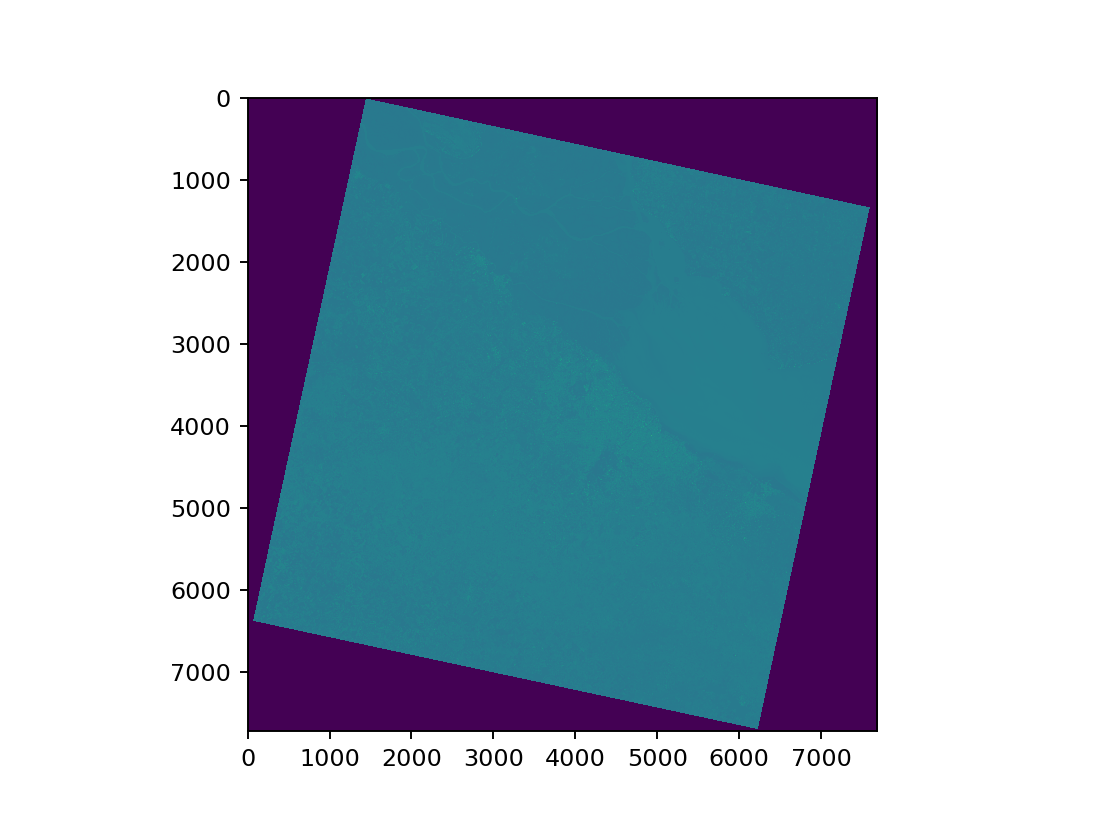

In [7]:
b3 = l8_stack.ReadAsArray()[3,:,:]
plt.imshow(b3)
#plt.savefig(src+'b3.jpg')

<IPython.core.display.Javascript object>


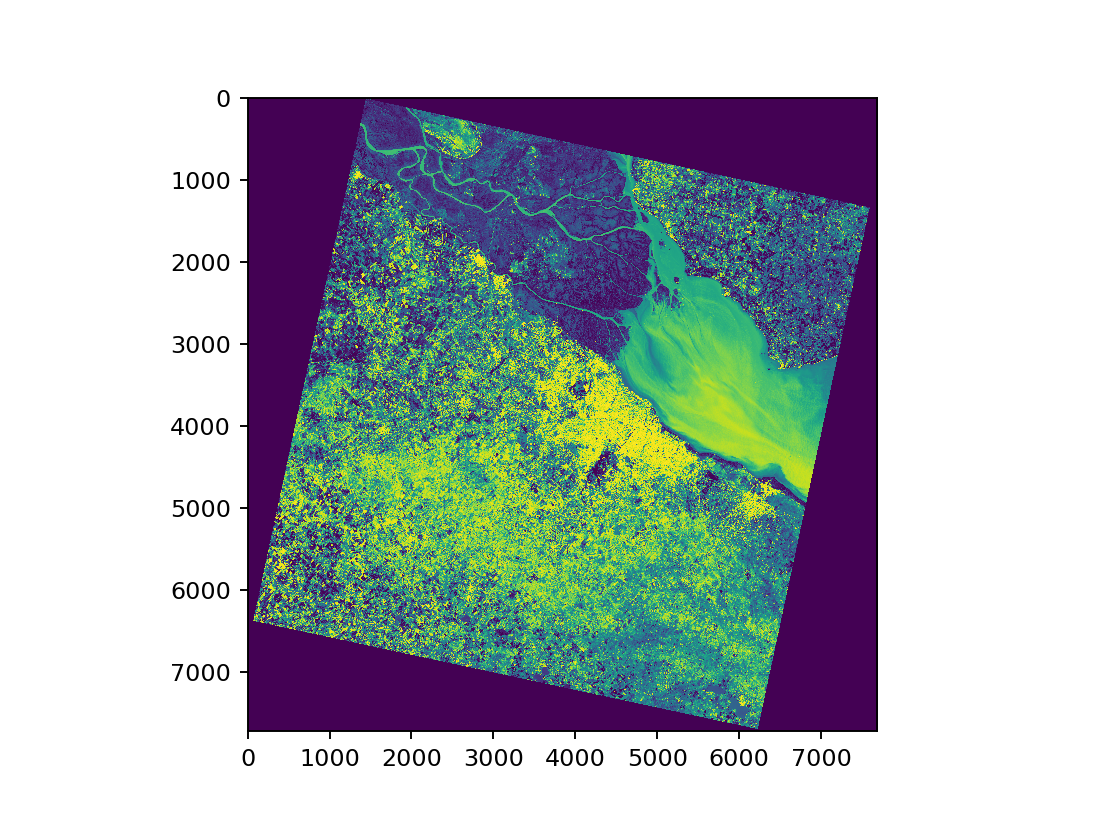

In [8]:
from skimage import exposure

b3_equa = exposure.equalize_hist(b3)
plt.imshow(b3_equa)
#plt.savefig(src+'b3_equa.jpg')

### 1.3 Pasamos a coordenadas geograficas:

In [6]:
l8_latlong_name = src+'l8_latlong.tif'
l8_latlong = gdal.Warp(l8_latlong_name,l8_stack,dstSRS='EPSG:4326')

#The gdalwarp utility is an image mosaicing, reprojection and warping utility.

# dstSRS -> output SRS (Spatial reference system)

In [7]:
del l8_stack #ya no la usamos mas

### 1.4 Realizamos un clip:


In [8]:
#bajo Delta:
xmin=-58.6
xmax=-58.4
ymin=-34.5
ymax=-34.29

l8_clip_name = src+'l8_clip.tif'
l8_clip = gdal.Warp(l8_clip_name,l8_latlong,outputBounds= (xmin,ymin,xmax,ymax))

In [9]:
del l8_latlong # ya no la usamos mas, ns quedamos con el clip

### Multiplicamos por 0.0001


In [10]:

l8_clip_array = 0.0001*l8_clip.ReadAsArray()

### 1.5 Obervamos el clip en RGB:

<IPython.core.display.Javascript object>


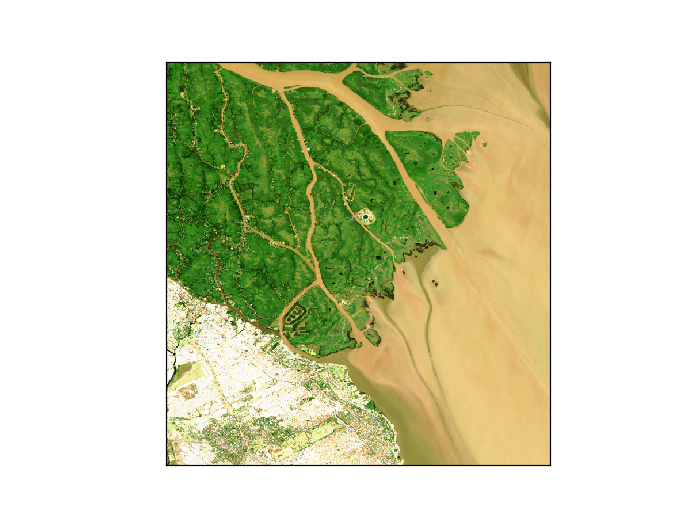

([], <a list of 0 Text yticklabel objects>)

In [12]:

#Stack arrays in sequence depth wise (along third axis).
img_r = l8_clip_array[3,:,:]
img_g = l8_clip_array[2,:,:]
img_b = l8_clip_array[1,:,:]

img_rgb = np.dstack([img_r,img_g,img_b])

img_rgb = exposure.equalize_hist(img_rgb)

plt.imshow(img_rgb)

plt.xticks([])
plt.yticks([])

#plt.savefig(src+'img_rgb.jpg')


In [ ]:
array2raster(src+'img_rgb.tif', img_rgb, l8_clip.GetGeoTransform(), l8_clip.GetProjection())





## 2. Extracción de polígonos con roipoly

#### Creacion de poligonos

Para esto utlizaremos la clase "roipoly", veamos como crear un poligono:

<IPython.core.display.Javascript object>


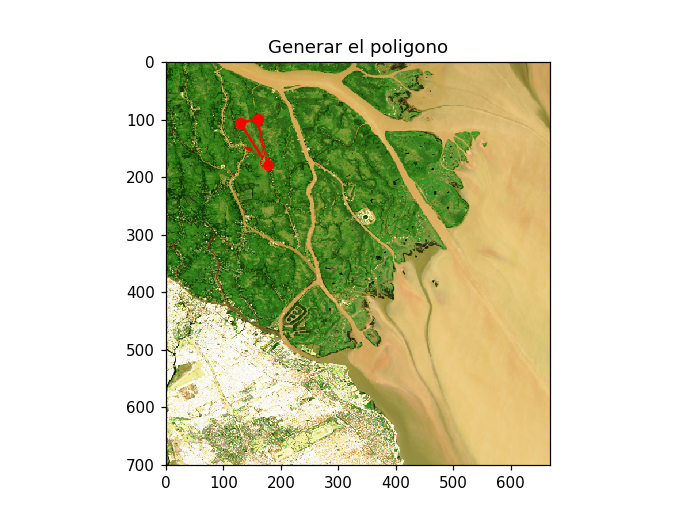

In [13]:
from roipoly import roipoly

plt.imshow(img_rgb)
plt.title('Generar el poligono')
pol1 = roipoly(roicolor='r')



#### Obtención de máscaras:
Podemos hallar la mascara generada por el polígono:
(¿Qué es una máscara?)


In [14]:
mask_pol1 = pol1.getMask(img_rgb[:,:,0])
mask_pol1
print(mask_pol1.shape)

(702, 669)


<IPython.core.display.Javascript object>


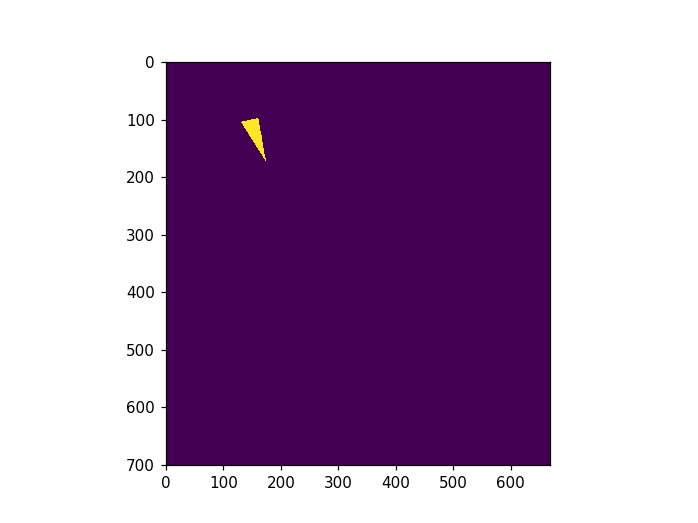

In [15]:

plt.imshow(mask_pol1)

##### Ahora, utilizando la máscara, obtener los valores de los pixeles que pertenecen al polígono:

In [16]:
valores_poli1_mask = l8_clip_array[:,mask_pol1]
valores_poli1_mask.shape

(7, 1201)

In [ ]:
#df = pd.DataFrame(valores_poli1_mask.T,columns=['Banda1','Banda2','Banda3','Banda4','Banda5','Banda6','Banda7']).head()
#df['clase']='vegetacion'
#df

##### Cómo podemos hacer para observar algun polígono ya marcado y crear uno nuevo?

Ahora mostramos el polígono marcado y creamos uno nuevo:

<IPython.core.display.Javascript object>


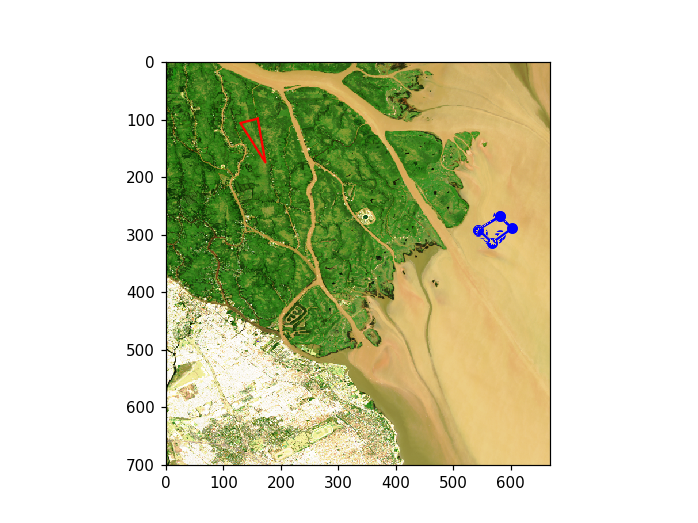

In [17]:
# Ploteamos la img:
plt.imshow(img_rgb)
# Ploteamos los poligonos calculando anteriormente:
[x.displayROI() for x in [pol1]]
# Armamos un nuevo poligono
pol2 = roipoly(roicolor='b')

#### Misión:
    1) En la imagen se pueden observar distintas regiones homogeneas. Marcar 3 polígonos distintos en la imagen rgb, cada uno de ellos correspondiente a una zona homogenea distinta. Llamar a los polígonos: pol1, pol2 y pol3
    2) Luego, extraer los valores (en todas las bandas) de los pixeles asociados a cada polígono. Llamar a cada conjunto de datos: valores_pol1, valores_pol2 y valores_pol3.

<IPython.core.display.Javascript object>


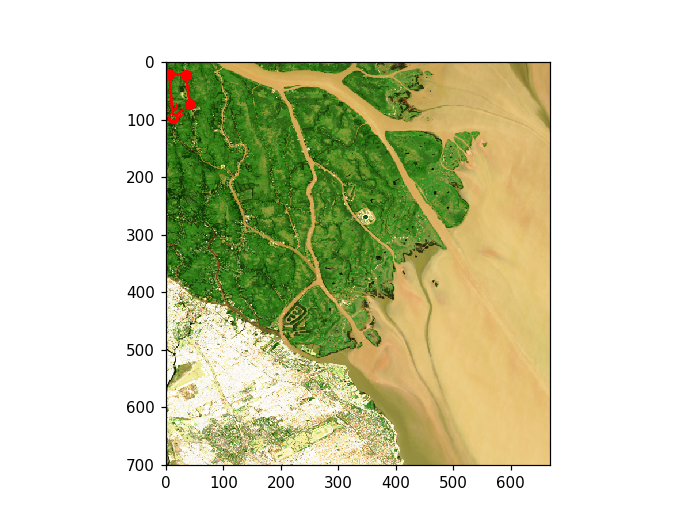

In [18]:

plt.imshow(img_rgb)
pol_1 = roipoly(roicolor='r') 

<IPython.core.display.Javascript object>


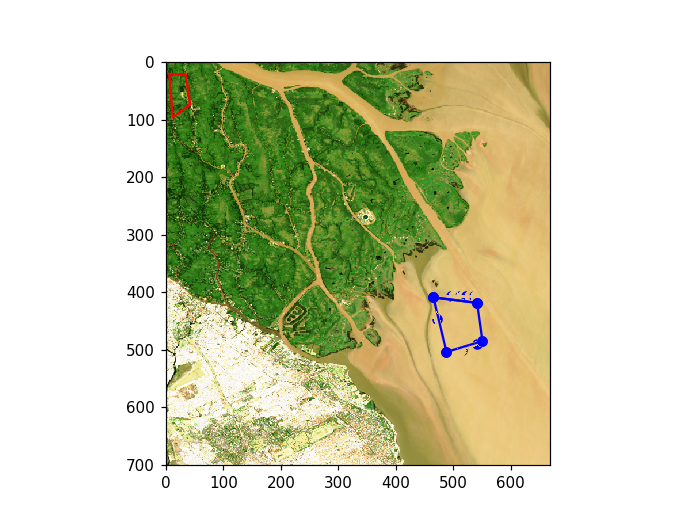

In [19]:
plt.imshow(img_rgb)
[x.displayROI() for x in [pol_1]]

pol_2 = roipoly(roicolor='b')

<IPython.core.display.Javascript object>


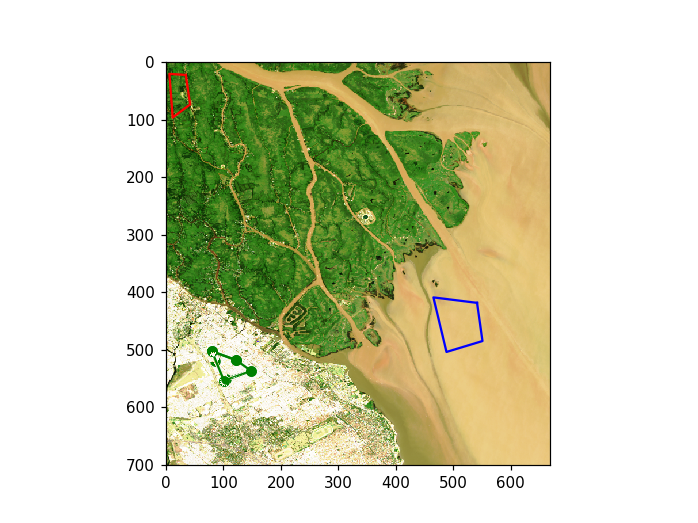

In [20]:
plt.imshow(img_rgb)
[x.displayROI() for x in [pol_1,pol_2]]

pol_3 = roipoly(roicolor='g')

<IPython.core.display.Javascript object>


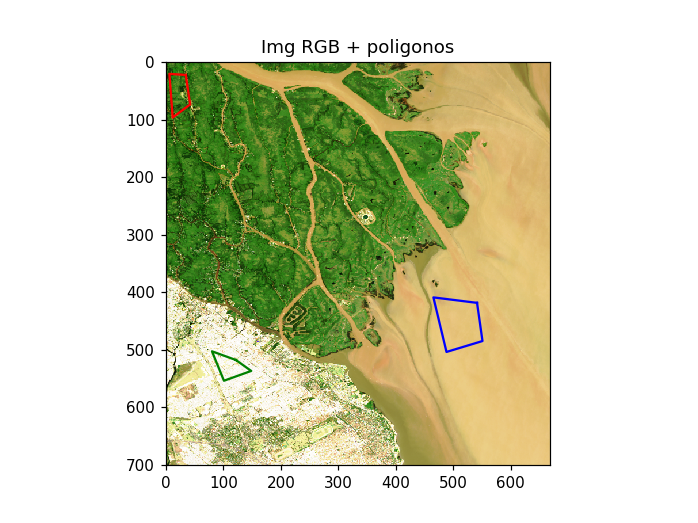

Text(0.5, 1.0, 'Img RGB + poligonos')

In [21]:
plt.imshow(img_rgb)
[x.displayROI() for x in [pol_1,pol_2,pol_3]]
plt.title('Img RGB + poligonos')

<IPython.core.display.Javascript object>


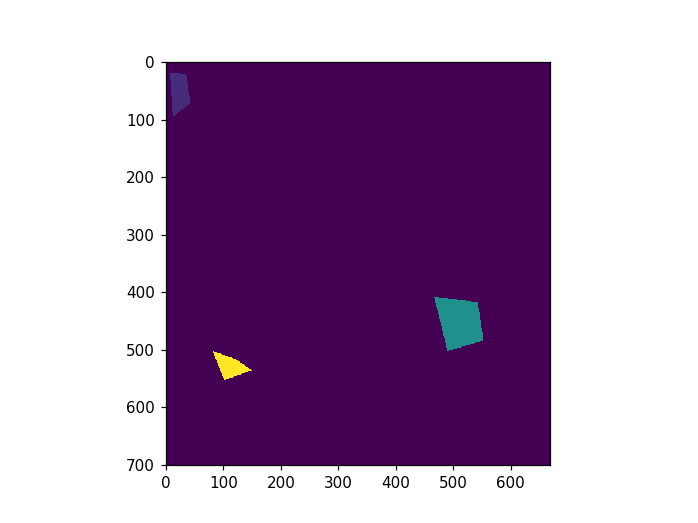

In [22]:

poli_1_mask = pol_1.getMask(img_r)
poli_2_mask = pol_2.getMask(img_r)
poli_3_mask = pol_3.getMask(img_r)


valores_poli_1_mask = l8_clip_array[:,poli_1_mask]
valores_poli_2_mask = l8_clip_array[:,poli_2_mask]
valores_poli_3_mask = l8_clip_array[:,poli_3_mask]

plt.imshow(poli_1_mask+4*poli_2_mask+8*poli_3_mask)

In [23]:
mask = poli_1_mask+4*poli_2_mask+8*poli_3_mask
array2raster_1band(src+'mask.tif', mask, l8_clip.GetGeoTransform(), l8_clip.GetProjection())

#### 2.1 Comparando las firmas espectrales, asociamos a cada polígono con un tipo de cobertura

Graficar las firmas espectrales asociadas a cada polígono

<IPython.core.display.Javascript object>


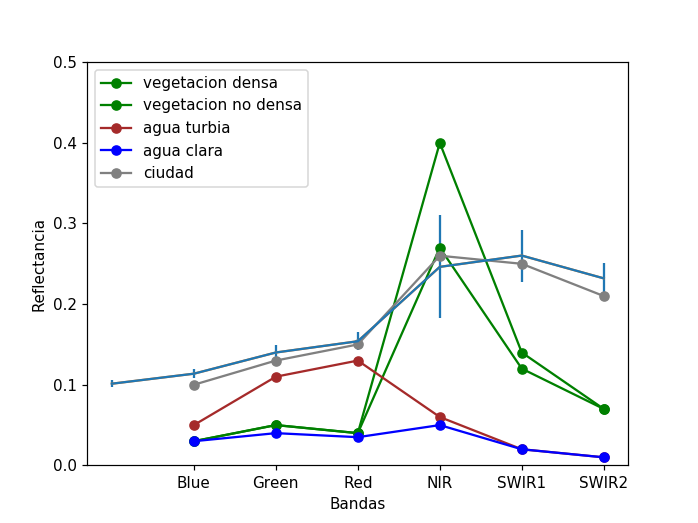

In [24]:
values = [valores_poli_1_mask,valores_poli_2_mask,valores_poli_3_mask]
x = [0,1,2,3,4,5,6]

#plt.xkcd()
for i in range(2,3):
    valor = values[i]
    plt.errorbar(x,np.mean(valor,axis=1),yerr=np.std(valores_poli_1_mask,axis=1))
    plt.plot(x,np.mean(valor,axis=1))

firmas_teo()

## Concluir cada polígono a que cobertura pertenece, cambiar los nombres:

In [43]:
valores_vegetacion = valores_poli_1_mask
valores_agua = valores_poli_2_mask
valores_ciudad = valores_poli_3_mask

#Para utilizar clases no pesadas (es decir, la misma cantidad de datos de entrenamiento de cada clase):

#min_val = np.min([valores_vegetacion.shape[1], valores_agua.shape[1],valores_ciudad.shape[1]])
# En este caso elegi los primeros min_val pixeles de cada clase pero utilizando np.random.choice(,replace=False) podriamos aleatorizar la 
# eleccion. Beneficio: si bien los pixeles estan dentro del mismo poligono difumino un poco la relacion espacial y obtengo una muestra con un poquito de variabilidad.

#valores_agua = valores_agua[:,0:min_val]
#valores_vegetacion = valores_vegetacion[:,0:min_val]
#valores_ciudad = valores_ciudad[:,0:min_val]

## 3. Crear un mapa de coberturas

### ¿Cómo podemos automatizar la clasificación en vez de ir analizando cada pixel por separado?

In [44]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split

x_data = np.concatenate((valores_agua.T,valores_vegetacion.T, valores_ciudad.T))

x_class = 4*np.concatenate((np.ones(valores_agua.shape[1]),2*np.ones(valores_vegetacion.shape[1]),3*np.ones(valores_ciudad.shape[1])))

x_train, x_test, y_train, y_test = train_test_split(x_data, x_class, test_size=0.3, random_state=4)

In [45]:

clf = KNN(n_neighbors=20,metric='euclidean')
clf.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform')

In [46]:
bands, rows, cols = l8_clip_array.shape

n_samples = rows*cols
flat_pixels = l8_clip_array.reshape((bands, n_samples))

result = clf.predict(flat_pixels.T)
classification = result.reshape((rows, cols))
np.unique(classification)

array([ 4.,  8., 12.])

<IPython.core.display.Javascript object>


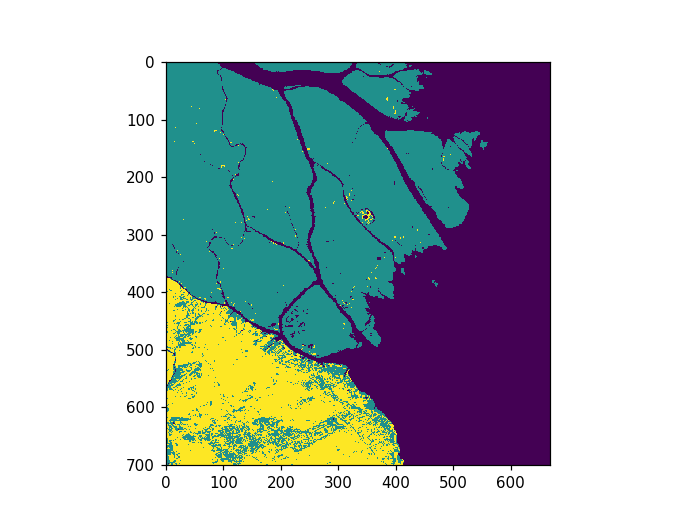

In [47]:
plt.imshow(classification)

<IPython.core.display.Javascript object>


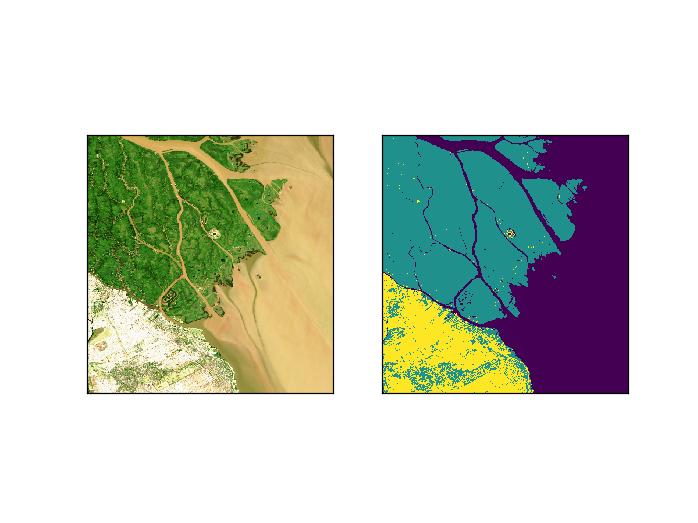

([], <a list of 0 Text yticklabel objects>)

In [48]:
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(classification)
plt.xticks([])
plt.yticks([])

Evaluacion

In [49]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

y_pred = clf.predict(x_test)

print(accuracy_score(y_test, y_pred, normalize=True))
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

0.998913830557567
              precision    recall  f1-score   support

         4.0       1.00      1.00      1.00      1698
         8.0       0.99      1.00      1.00       593
        12.0       1.00      0.99      1.00       471

   micro avg       1.00      1.00      1.00      2762
   macro avg       1.00      1.00      1.00      2762
weighted avg       1.00      1.00      1.00      2762



In [50]:
confusion_matrix(y_test, y_pred)

array([[1698,    0,    0],
       [   0,  593,    0],
       [   0,    3,  468]])

<IPython.core.display.Javascript object>


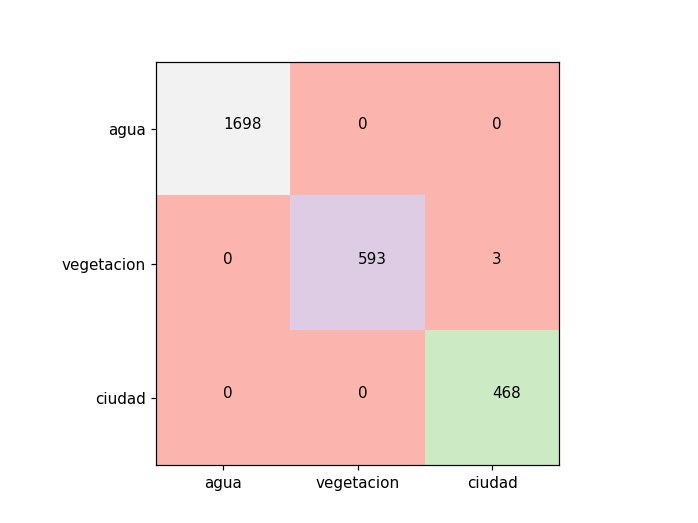

([<matplotlib.axis.YTick at 0x7fa97db14668>,
 <a list of 3 Text yticklabel objects>)

In [51]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.clf()
plt.imshow(cm,interpolation='nearest',cmap='Pastel1')#cmap='PiYG')
for i in range(3):
    for j in range(3):
        plt.text(i,j,str(cm[i][j]))
plt.show()

classNames = ['agua','vegetacion','ciudad']
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)

In [52]:
print(valores_agua.shape[1])
print(valores_vegetacion.shape[1])
print(valores_ciudad.shape[1])

5671
1944
1589


### Y luego de tanto trabajo, no olvidemos guardar nuestro exitoso resultado!

In [53]:
#array2raster(out_name, array, geo_trans, proj)

out_name= src+'clasificacion.tif'
array= classification
geo_trans= l8_clip.GetGeoTransform()
proj= l8_clip.GetProjection()

array2raster_1band(out_name, array, geo_trans, proj)

<IPython.core.display.Javascript object>


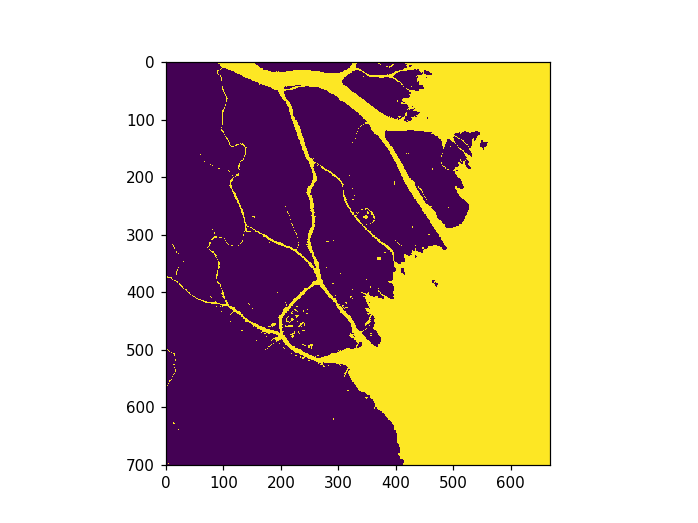

In [54]:
test = gdal.Open(out_name)

plt.imshow(test.ReadAsArray()==4)